In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Activity 1

In [5]:
## Setting up a class for data 
class Data():
    ''' 
    Class that outputs data drawn from 2d Gaussian distribution belonging to two
    class labels.
    Inputs:
    mean1 - mean of class1 samples
    mean2 - mean of class2 samples
    cov1 - covariance matrix for class1 samples
    cov2 - covariance matrix for class2 samples

    Returns - numpy arrays of:
    class1 samples
    class2 samples
    target values for class1 training data (1)
    target values for class2 training data (-1)
    '''
    def __init__(self,**kwargs):
        self.mean1 = kwargs['mean1']
        self.mean2 = kwargs['mean2']
        self.N1 = kwargs['N1']
        self.cov1 = kwargs['cov1']
        self.cov2 = kwargs['cov2']
        self.N2 = kwargs['N2']
        self.class1_samples = np.random.multivariate_normal(mean=self.mean1,
                                                             cov=self.cov1,
                                                             size=self.N1)
        self.class2_samples = np.random.multivariate_normal(mean=self.mean2,
                                                             cov=self.cov2,
                                                             size=self.N2)
        self.target1 = np.ones(self.N1) ## target values for class1
        self.target2 = -np.ones(self.N2) ## target values for class2
        

In [7]:
## parameters that replicate data from Fig 4.6
data_params = {
    'mean1': [0.5,4],
    'cov1' : [[3,0.0],[0.0,0.25]],
    'mean2' : [6,1],
    'cov2' : [[3,0.0],[0.0,0.25]],
    }

In [9]:
## Create training data and testing data
training_data = Data(N1 = 250,N2=250,**data_params)
test_data = Data(N1=50,N2=50,**data_params)

### Least Square Classifier

In [12]:
class LeastSquareClassifier():
    def __init__(self,**kwargs):
        self.training = kwargs['training_data']
        self.T_matrix = np.hstack((self.training.target1,
                                   self.training.target2)).reshape(self.training.N1 \
                                                                   +self.training.N2,
                                                                   1)
        self.X = np.vstack((self.training.class1_samples,
                            self.training.class2_samples))
        self.X_tilde = np.hstack((np.ones((self.X.shape[0],1)),self.X))
        self.W_tilde = (np.linalg.inv(self.X_tilde.T@self.X_tilde)
                        @self.X_tilde.T@self.T_matrix).flatten()
        
    def decision_surface(self):
        ''' 
        Dict : returns the slope and intercept of the decision surface
        '''
        return {'slope': -self.W_tilde[1]/self.W_tilde[2],
                'intercept' : -self.W_tilde[0]/self.W_tilde[2]}
    
    def class_labels(self,data):
        ''' 
        Input : test data of the type 'Data' class
        Returns the class labels for each point 
        +1 -> class 1
        -1 -> class 2
        '''
        samples = np.vstack((data.class1_samples,data.class2_samples))
        prediction_values = self.W_tilde[0]+ np.dot(samples,self.W_tilde[1:])
        prediction_labels = np.sign(prediction_values)
        return prediction_labels
    
    def classify(self,data):
        """ 
        Input : Test data
        Returns the data classified into 2 classes as a dictionary
        """
        samples = np.vstack((data.class1_samples,data.class2_samples))
        print(samples)
        labels = self.class_labels(data)
        return {
            'class1' : samples[labels >= 0],
            'class2' : samples[labels < 0]
        }
    
    def confusion_matrix(self,data):
        ''' 
        Input test data
        returns the confusion matrix 
        '''
        cm=np.zeros((2,2))
        targets = np.hstack((data.target1,data.target2))
        predictions = self.class_labels(data)
        for i in range(len(targets)):
            if targets[i]>=0 and predictions[i]>=1:
                cm[0][0]+=1
            if targets[i]>=0 and predictions[i]==-1:
                cm[0][1]+=1
            if targets[i]==-1 and predictions[i]>=0:
                cm[1][0]+=1
            if targets[i]==-1 and predictions[i]==-1:
                cm[1][1]+=1
        return cm
        

In [14]:
## Create an instance of the least square classifier for the given training data
lsc = LeastSquareClassifier(training_data=training_data)

In [16]:
## Returns the slope and intercept of the decision surface
lsc_surface = lsc.decision_surface()
print('Decision surface parameters (Least Square Classifier)')
print(lsc_surface)

Decision surface parameters (Least Square Classifier)
{'slope': 0.15391541857044763, 'intercept': 1.986592487817092}


In [18]:

## Confusion matrix for the testing data
lsc_cm = lsc.confusion_matrix(test_data)
print('Confusion Matrix (Least Square Classifier)')
print(lsc_cm)

Confusion Matrix (Least Square Classifier)
[[49.  1.]
 [ 0. 50.]]


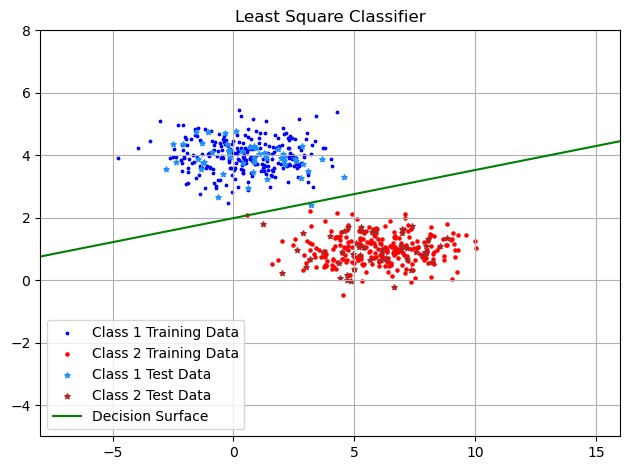

In [20]:
## Plot the samples and the decision surface
plt.scatter(training_data.class1_samples[:,0],
            training_data.class1_samples[:,1],
            label = 'Class 1 Training Data',
            c='blue',s=3,alpha=1)

plt.scatter(training_data.class2_samples[:,0],
            training_data.class2_samples[:,1],
            label = 'Class 2 Training Data',
            c='red',s=5,alpha=1)

plt.scatter(test_data.class1_samples[:,0],
            test_data.class1_samples[:,1],
            label = 'Class 1 Test Data',
            c='dodgerblue',s=15,marker='*')

plt.scatter(test_data.class2_samples[:,0],
            test_data.class2_samples[:,1],
            label = 'Class 2 Test Data',
            c='firebrick',s=15,marker='*')

x_range=np.linspace(-8,16,100)
plt.plot(x_range,
         lsc_surface['slope']*x_range+lsc_surface['intercept'],
         label='Decision Surface',color='green')

plt.xlim([-8,16])
plt.ylim([-5,8])
plt.title("Least Square Classifier")
plt.legend()
plt.tight_layout()
plt.grid()
#plt.savefig('act1_fig1.png',dpi=300)

### Fisher Linear Discriminant

In [23]:
class FisherLinear():
    def __init__(self,**kwargs):
        self.training = kwargs['training_data']
        #print(self.training.class1_samples)
        self.mean1 = np.mean(self.training.class1_samples,axis=0)
        self.mean2 = np.mean(self.training.class2_samples,axis=0)
        self.dx1 = self.training.class1_samples - self.mean1
        self.dx2 = self.training.class2_samples - self.mean2
        self.cov1 = np.sum(np.array([np.outer(dx1,dx1) for dx1 in self.dx1]),axis=0)
        self.cov2 = np.sum(np.array([np.outer(dx2,dx2) for dx2 in self.dx2]),axis=0)
        self.cov_total = self.cov1 + self.cov2
        self.cov_inv =np.linalg.inv(self.cov_total)
        self.w_tilde = self.cov_inv@(self.mean1 - self.mean2)
        self.w = self.w_tilde/np.linalg.norm(self.w_tilde)
        self.threshold = 0.5 * self.w @ (self.mean1.T+self.mean2.T) 
    
    def projection_surface(self):
        return {'slope' : self.w[1]/self.w[0]}
    
    def discriminant(self,data):
        discriminant_class1 = self.w@data.class1_samples.T
        discriminant_class2 = self.w@data.class2_samples.T
        return{
            'class1' : discriminant_class1,
            'class2' : discriminant_class2
        }
    
    def classify(self,data):
        samples = np.vstack((data.class1_samples,data.class2_samples))
        discriminant_vals = np.hstack((self.discriminant(data)['class1'],
                                       self.discriminant(data)['class2']))
        return {
            'class1' : samples[discriminant_vals >= self.threshold],
            'class2' : samples[discriminant_vals < self.thresholdd]
        }
    
    def confusion_matrix(self,data):
        pass



        

In [25]:
## Create an instance of the classifier using training data
FL = FisherLinear(training_data=training_data)

In [27]:
fld_surface = FL.projection_surface()
print('Projection surface')
print(fld_surface)

Projection surface
{'slope': -6.497074882347223}


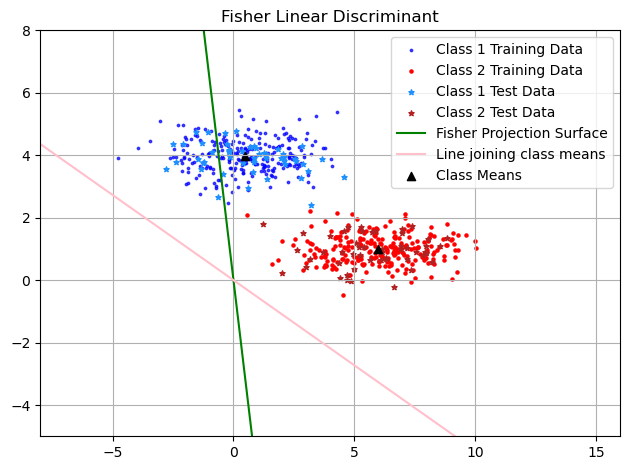

In [29]:
## Plot the Fisher projection surface and the line joining the means.
plt.scatter(training_data.class1_samples[:,0],
            training_data.class1_samples[:,1],
            label = 'Class 1 Training Data',
            c='blue',s=3,alpha=0.7)

plt.scatter(training_data.class2_samples[:,0],
            training_data.class2_samples[:,1],
            label = 'Class 2 Training Data',
            c='red',s=5,alpha=1)

plt.scatter(test_data.class1_samples[:,0],
            test_data.class1_samples[:,1],
            label = 'Class 1 Test Data',
            c='dodgerblue',s=15,marker='*')

plt.scatter(test_data.class2_samples[:,0],
            test_data.class2_samples[:,1],
            label = 'Class 2 Test Data',
            c='firebrick',s=15,marker='*')

plt.plot(x_range,fld_surface['slope']*(x_range),
         label = 'Fisher Projection Surface',
         color='green')

plt.plot(x_range,
         ((FL.mean1[1]-FL.mean2[1])/(FL.mean1[0]-FL.mean2[0]))*(x_range),
         label = 'Line joining class means',color = 'pink')

plt.scatter([FL.mean1[0],FL.mean2[0]],
            [FL.mean1[1],FL.mean2[1]],
            label='Class Means', c='black', marker='^',s=35 )

plt.xlim([-8,16])
plt.ylim([-5,8])
plt.title("Fisher Linear Discriminant")
plt.legend()
plt.tight_layout()
plt.grid()
#plt.savefig('act1_fig2.png',dpi=300)

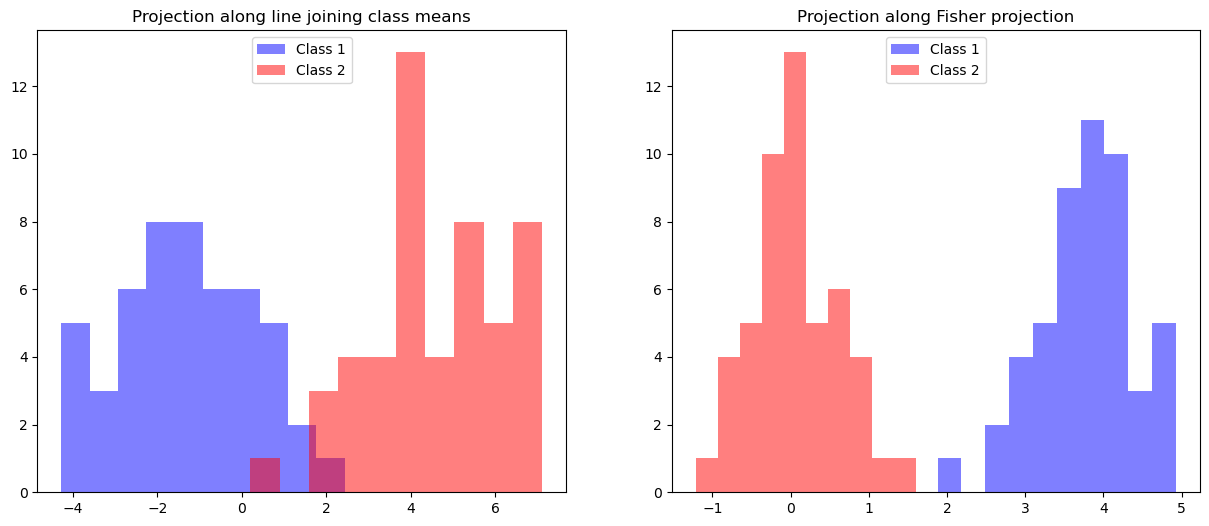

In [31]:
## Plotting the projection histogram

dmean_slope = (FL.mean1[1]-FL.mean2[1])/(FL.mean1[0]-FL.mean2[0])
w_dmean = np.array([1,dmean_slope])/np.sqrt(1 + dmean_slope**2)

fig,axs = plt.subplots(1,2,figsize=(15,6))

axs[0].hist(w_dmean@test_data.class1_samples.T,
            label = 'Class 1',color='blue',alpha=0.5)
axs[0].hist(w_dmean@test_data.class2_samples.T,
            label = 'Class 2',color='red',alpha=0.5)
axs[1].hist(FL.discriminant(test_data)['class1'],
            label = 'Class 1', color='blue', alpha=0.5)
axs[1].hist(FL.discriminant(test_data)['class2'],
            label = 'Class 2', color='red', alpha=0.5)
axs[0].set_title('Projection along line joining class means')
axs[1].set_title('Projection along Fisher projection')
axs[0].legend(loc='upper center')
axs[1].legend(loc='upper center')
#plt.savefig('act1_fig3.png',dpi=300)

In [53]:
## Confusion matrix for the testing data
cm = confusion_matrix(y_test, y_pred)
#fisher_cm = FisherLinear.confusion_matrix(test_data)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[49  1]
 [ 2 48]]


## Perceptron

Perceptron Confusion Matrix:
[[49  1]
 [ 2 48]]
Perceptron Accuracy: 0.9700


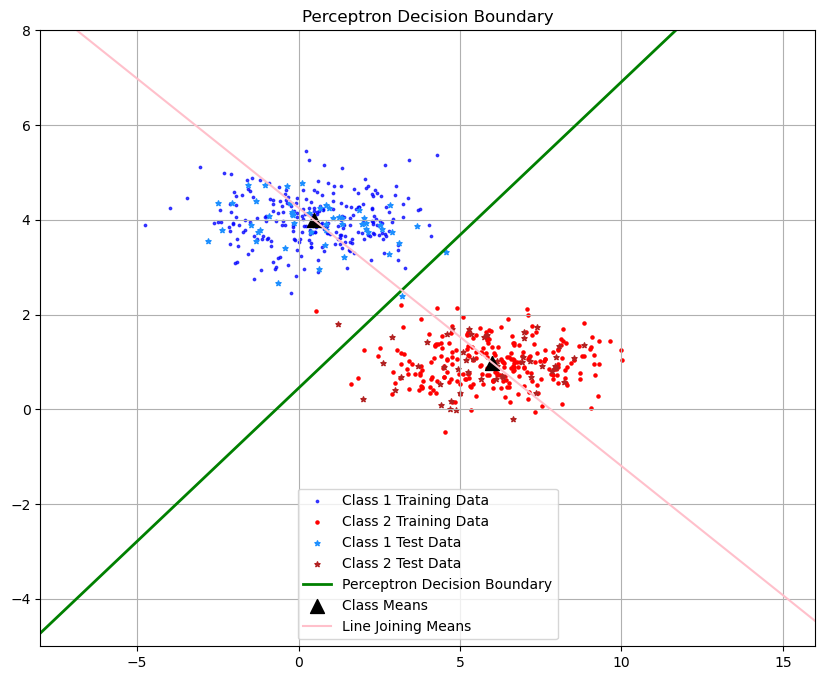

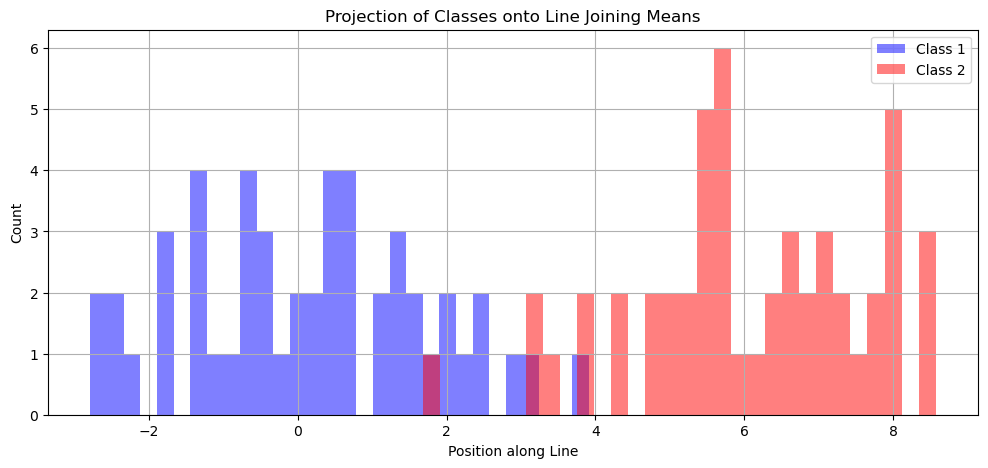

In [45]:
# Part 1c: Perceptron Implementation using your existing data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Perceptron

X_train = np.vstack((training_data.class1_samples, training_data.class2_samples))
y_train = np.hstack((np.ones(len(training_data.class1_samples)), -np.ones(len(training_data.class2_samples))))

X_test = np.vstack((test_data.class1_samples, test_data.class2_samples))
y_test = np.hstack((np.ones(len(test_data.class1_samples)), -np.ones(len(test_data.class2_samples))))

# Train the Perceptron on combined data
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
perceptron.fit(X_train, y_train)

# Predict on test data
y_pred = perceptron.predict(X_test)

# Compute confusion matrix
conf_matrix_perceptron = confusion_matrix(y_test, y_pred)
print("Perceptron Confusion Matrix:")
print(conf_matrix_perceptron)

# Calculate accuracy
accuracy_perceptron = np.sum(np.diag(conf_matrix_perceptron)) / np.sum(conf_matrix_perceptron)
print(f"Perceptron Accuracy: {accuracy_perceptron:.4f}")

# Visualize decision boundary and data
plt.figure(figsize=(10, 8))

# Plot all data
plt.scatter(training_data.class1_samples[:, 0], training_data.class1_samples[:, 1], 
            label='Class 1 Training Data', c='blue', s=3, alpha=0.7)
plt.scatter(training_data.class2_samples[:, 0], training_data.class2_samples[:, 1], 
            label='Class 2 Training Data', c='red', s=5, alpha=1)
plt.scatter(test_data.class1_samples[:, 0], test_data.class1_samples[:, 1], 
            label='Class 1 Test Data', c='dodgerblue', s=15, marker='*')
plt.scatter(test_data.class2_samples[:, 0], test_data.class2_samples[:, 1], 
            label='Class 2 Test Data', c='firebrick', s=15, marker='*')

# Decision boundary
# Calculate the decision boundary line
x_points = np.array([-8, 16])
y_points = -(w[0] * x_points + b) / w[1]
# Plot the line
plt.plot(x_points, y_points, 'g-', linewidth=2, label='Perceptron Decision Boundary')
xx, yy = np.meshgrid(np.linspace(-8, 16, 200), np.linspace(-5, 8, 200))
Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
w = perceptron.coef_[0]
b = perceptron.intercept_[0]


#plt.contour(xx, yy, Z, levels=[0], colors='green', linewidths=2, linestyles='solid', label='Perceptron Decision Boundary')


# Plot class means
mean1 = np.mean(training_data.class1_samples, axis=0)
mean2 = np.mean(training_data.class2_samples, axis=0)
plt.scatter([mean1[0], mean2[0]], [mean1[1], mean2[1]], c='black', marker='^', s=100, label='Class Means')

# Plot line joining means
slope = (mean2[1] - mean1[1]) / (mean2[0] - mean1[0])
x_range = np.linspace(-8, 16, 100)
plt.plot(x_range, slope * (x_range - mean1[0]) + mean1[1], 'pink', label='Line Joining Means')

# Set plot limits and labels
plt.xlim([-8, 16])
plt.ylim([-5, 8])
plt.title("Perceptron Decision Boundary")
plt.legend()
plt.grid(True)
plt.show()

# Project data onto the line joining means
line_vector = mean2 - mean1
line_vector = line_vector / np.linalg.norm(line_vector)  # Normalize

# Project test data
projections_class1 = np.dot(test_data.class1_samples - mean1, line_vector)
projections_class2 = np.dot(test_data.class2_samples - mean1, line_vector)

# Plot projections
plt.figure(figsize=(12, 5))
plt.hist(projections_class1, bins=30, alpha=0.5, label='Class 1', color='blue')
plt.hist(projections_class2, bins=30, alpha=0.5, label='Class 2', color='red')
plt.title("Projection of Classes onto Line Joining Means")
plt.xlabel("Position along Line")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

# Activity 2

Ridge Regression with different regularization strengths:
Ridge Regression (alpha=0.001) Confusion Matrix:
[[50  0]
 [ 1 49]]
Accuracy: 0.9900
----------------------------------------
Ridge Regression (alpha=0.01) Confusion Matrix:
[[50  0]
 [ 1 49]]
Accuracy: 0.9900
----------------------------------------
Ridge Regression (alpha=0.1) Confusion Matrix:
[[50  0]
 [ 1 49]]
Accuracy: 0.9900
----------------------------------------
Ridge Regression (alpha=1.0) Confusion Matrix:
[[50  0]
 [ 1 49]]
Accuracy: 0.9900
----------------------------------------
Ridge Regression (alpha=10.0) Confusion Matrix:
[[50  0]
 [ 1 49]]
Accuracy: 0.9900
----------------------------------------
Ridge Regression (alpha=100.0) Confusion Matrix:
[[50  0]
 [ 1 49]]
Accuracy: 0.9900
----------------------------------------

Best alpha: 0.001, Accuracy: 0.9900


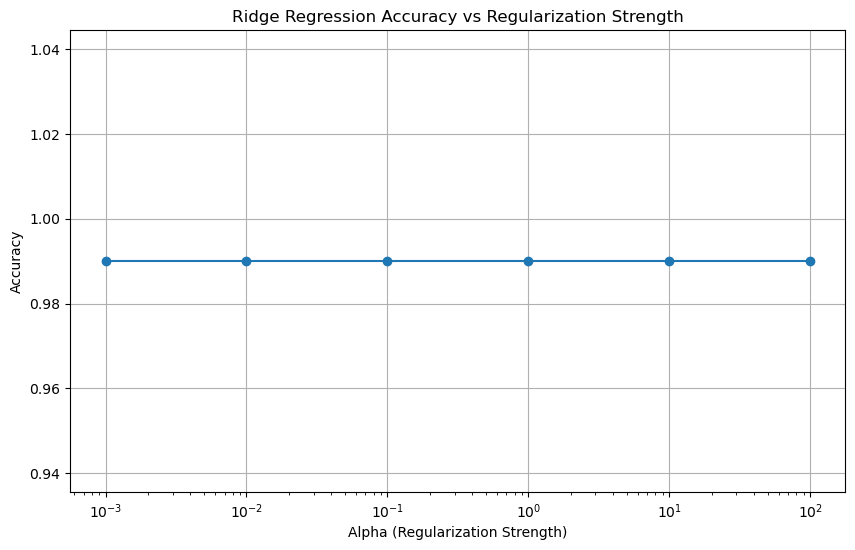

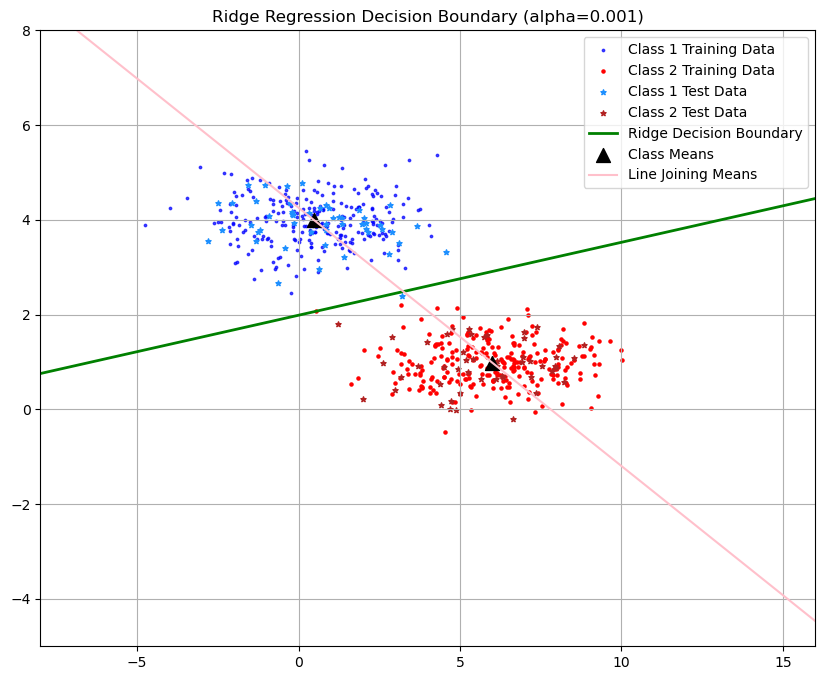

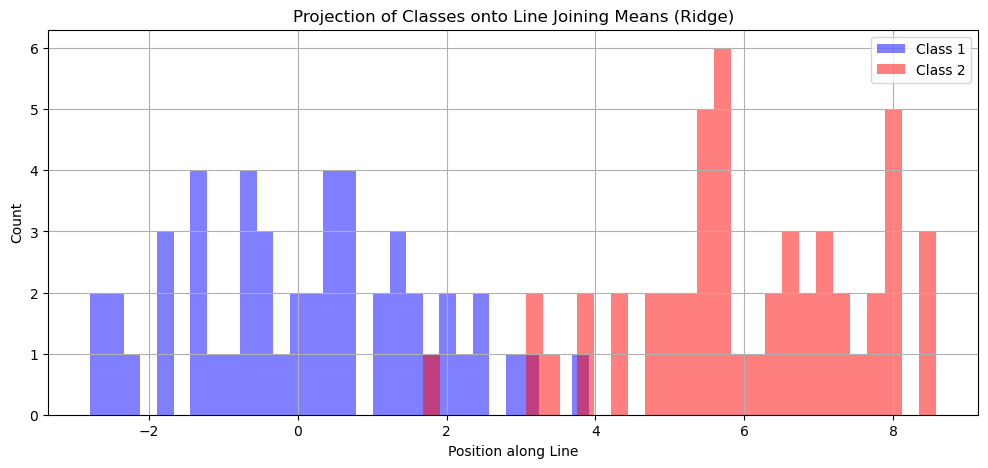


Unregularized Least Squares Confusion Matrix:
[[50  0]
 [ 1 49]]
Accuracy: 0.9900

Summary of All Methods:
Unregularized Least Squares accuracy: 0.9900
Ridge Regression (alpha=0.001) accuracy: 0.9900


In [49]:
# Part 2: Least Square Classification with Regularization (Ridge Regression)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import confusion_matrix

# Combine data from both classes for training
X_train = np.vstack((training_data.class1_samples, training_data.class2_samples))
y_train = np.hstack((np.ones(len(training_data.class1_samples)), -np.ones(len(training_data.class2_samples))))

# Combine test data
X_test = np.vstack((test_data.class1_samples, test_data.class2_samples))
y_test = np.hstack((np.ones(len(test_data.class1_samples)), -np.ones(len(test_data.class2_samples))))

# Test different regularization parameters
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
accuracy_scores = []
confusion_matrices = {}

print("Ridge Regression with different regularization strengths:")
for alpha in alphas:
    # Train Ridge Regression model
    ridge = Ridge(alpha=alpha, solver='auto')
    ridge.fit(X_train, y_train)
    
    # Make predictions
    y_pred_ridge = np.sign(ridge.predict(X_test))  # Sign to convert to binary classes
    
    # Compute confusion matrix
    conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)
    confusion_matrices[alpha] = conf_matrix_ridge
    
    # Calculate accuracy
    accuracy = np.sum(np.diag(conf_matrix_ridge)) / np.sum(conf_matrix_ridge)
    accuracy_scores.append(accuracy)
    
    print(f"Ridge Regression (alpha={alpha}) Confusion Matrix:")
    print(conf_matrix_ridge)
    print(f"Accuracy: {accuracy:.4f}")
    print("-" * 40)

# Find best alpha
best_alpha = alphas[np.argmax(accuracy_scores)]
print(f"\nBest alpha: {best_alpha}, Accuracy: {max(accuracy_scores):.4f}")

# Plot accuracy vs alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, accuracy_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Ridge Regression Accuracy vs Regularization Strength')
plt.grid(True)
plt.show()

# Visualize decision boundary for best alpha
ridge = Ridge(alpha=best_alpha, solver='auto')
ridge.fit(X_train, y_train)

plt.figure(figsize=(10, 8))

# Plot all data
plt.scatter(training_data.class1_samples[:, 0], training_data.class1_samples[:, 1], 
            label='Class 1 Training Data', c='blue', s=3, alpha=0.7)
plt.scatter(training_data.class2_samples[:, 0], training_data.class2_samples[:, 1], 
            label='Class 2 Training Data', c='red', s=5, alpha=1)
plt.scatter(test_data.class1_samples[:, 0], test_data.class1_samples[:, 1], 
            label='Class 1 Test Data', c='dodgerblue', s=15, marker='*')
plt.scatter(test_data.class2_samples[:, 0], test_data.class2_samples[:, 1], 
            label='Class 2 Test Data', c='firebrick', s=15, marker='*')

# Decision boundary
w = ridge.coef_
b = ridge.intercept_

# Calculate the decision boundary line
x_points = np.array([-8, 16])
y_points = -(w[0] * x_points + b) / w[1]

# Plot the line
plt.plot(x_points, y_points, 'g-', linewidth=2, label='Ridge Decision Boundary')
xx, yy = np.meshgrid(np.linspace(-8, 16, 200), np.linspace(-5, 8, 200))
Z = np.sign(ridge.predict(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
#plt.contour(xx, yy, Z, levels=[0], colors='green', linewidths=2, linestyles='solid', label='Ridge Decision Boundary')

# Plot class means
mean1 = np.mean(training_data.class1_samples, axis=0)
mean2 = np.mean(training_data.class2_samples, axis=0)
plt.scatter([mean1[0], mean2[0]], [mean1[1], mean2[1]], c='black', marker='^', s=100, label='Class Means')

# Plot line joining means
slope = (mean2[1] - mean1[1]) / (mean2[0] - mean1[0])
x_range = np.linspace(-8, 16, 100)
plt.plot(x_range, slope * (x_range - mean1[0]) + mean1[1], 'pink', label='Line Joining Means')

plt.xlim([-8, 16])
plt.ylim([-5, 8])
plt.title(f"Ridge Regression Decision Boundary (alpha={best_alpha})")
plt.legend()
plt.grid(True)
plt.show()

# Project data onto the line joining means for Ridge
line_vector = mean2 - mean1
line_vector = line_vector / np.linalg.norm(line_vector)  # Normalize

# Project test data
projections_class1 = np.dot(test_data.class1_samples - mean1, line_vector)
projections_class2 = np.dot(test_data.class2_samples - mean1, line_vector)

# Plot projections
plt.figure(figsize=(12, 5))
plt.hist(projections_class1, bins=30, alpha=0.5, label='Class 1', color='blue')
plt.hist(projections_class2, bins=30, alpha=0.5, label='Class 2', color='red')
plt.title("Projection of Classes onto Line Joining Means (Ridge)")
plt.xlabel("Position along Line")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

# Compare with unregularized least squares (alpha=0)
ridge_unregularized = Ridge(alpha=0, solver='auto')
ridge_unregularized.fit(X_train, y_train)
y_pred_unreg = np.sign(ridge_unregularized.predict(X_test))
conf_matrix_unreg = confusion_matrix(y_test, y_pred_unreg)
accuracy_unreg = np.sum(np.diag(conf_matrix_unreg)) / np.sum(conf_matrix_unreg)

print("\nUnregularized Least Squares Confusion Matrix:")
print(conf_matrix_unreg)
print(f"Accuracy: {accuracy_unreg:.4f}")

# Summary comparison
print("\nSummary of All Methods:")
print(f"Unregularized Least Squares accuracy: {accuracy_unreg:.4f}")
print(f"Ridge Regression (alpha={best_alpha}) accuracy: {max(accuracy_scores):.4f}")